# MNIST Dataset: Error Detection

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, svm
from sklearn import metrics

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())




#custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

from density_forest.density_forest import *
from density_forest.helpers import *
from density_forest.plots import *
from baselines.helpers import *
from helpers.helpers import *
from helpers.plots import *
from parametric_tSNE.utils import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9033334075720360849
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 2
}
incarnation: 11884314433031200925
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train_label), (x_test, y_test_label) = mnist.load_data()

In [3]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train_label, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test_label, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights.h5')
else :
    model = load_model('mnist_models/mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions

In [5]:
y_pred_tr = model.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, background=False)

y_pred_te = model.predict(x_test)
y_pred_label_te = get_y_pred_labels(y_pred_te, background=False)

In [6]:
c = get_acc_net_max_margin(y_pred_te)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 99.06 %
Std accuracy: 7.08 %
97.47% of all predictions made with an accuracy higher than 0.95%


# Network
MSR, Margin, Entropy

In [7]:
# metrics
y_true = (y_pred_label_te != y_test_label)*1

# msr
y_scores = 1-get_acc_net_msr(y_pred_te)
# PR
precision_msr, recall_msr, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
# ROC
roc_auc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = 1-get_acc_net_max_margin(y_pred_te)
# PR
precision_margin, recall_margin, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
# ROC
roc_auc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = 1-get_acc_net_entropy(y_pred_te)
# PR
precision_entropy, recall_entropy, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
# ROC
roc_auc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

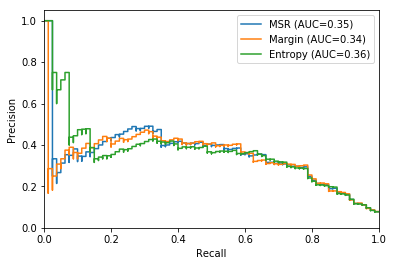

In [8]:
# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin,precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)' % pr_auc_msr),
            str.format('Margin (AUC=%.2f)' % pr_auc_margin),
            str.format('Entropy (AUC=%.2f)' % pr_auc_entropy)])

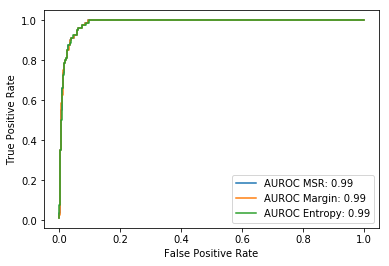

In [9]:
# ROC
plt.plot(fpr_msr,tpr_msr)
plt.plot(fpr_margin,tpr_margin)
plt.plot(fpr_entropy,tpr_entropy)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([str.format('AUROC MSR: %.2f') % roc_auc_msr,
            str.format('AUROC Margin: %.2f') % roc_auc_margin,
            str.format('AUROC Entropy: %.2f') % roc_auc_entropy
           ])

# Dropout

In [10]:
y_preds = predict_with_dropouts_batch(model, x_test, 
                                      batch_size=100, n_iter=20)

100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


In [11]:
y_pred = np.mean(y_preds, axis=0)
probas = np.mean(np.std(y_preds, -1),0)

0.30309524842391167


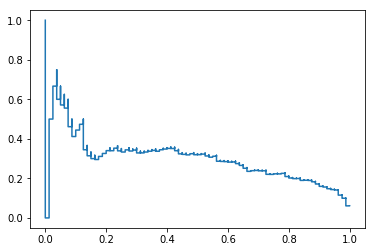

In [12]:
# precision-recall curve
y_scores = -probas
precision_dropout, recall_dropout, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_dropout = metrics.roc_auc_score(y_true, y_scores)

plt.step(recall_dropout,precision_dropout)
print(metrics.auc(recall_dropout, precision_dropout))

## Get Activations, PCA, t-SNE

In [13]:
y_pred_tr = model.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, background=False)

In [14]:
pred_f_tr = np.where(y_pred_label_tr != y_train_label)[0]
pred_t_tr = np.where(y_pred_label_tr == y_train_label)[0]

pred_f_te = np.where(y_pred_label_te != y_test_label)[0]
pred_t_te = np.where(y_pred_label_te == y_test_label)[0]

In [15]:
from keras import backend as k


In [16]:
# get activations of last layer
n_points = 15000
act_train_all = get_activations_batch(model, -2, x_train, batch_size=1000)
act_train = act_train_all[pred_t_tr]
print(np.shape(act_train_all))

act_test = get_activations(model, -2, x_test)[0]
print(np.shape(act_test))

(60000, 128)
(10000, 128)


In [17]:
pts_per_class = 300
n_classes=10
dataset_subset_indices = get_balanced_subset_indices(y_test_label, np.arange(n_classes), pts_per_class)

In [18]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
#tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

In [19]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0,1,n_classes))[:,:3]
names = ['Class '+str(i) for i in range(10)]
classes_to_keep = np.unique(y_test_label)

# plot
tsne_y = y_test_label[np.concatenate(dataset_subset_indices)]

Variance explained by first 15 components: 0.84


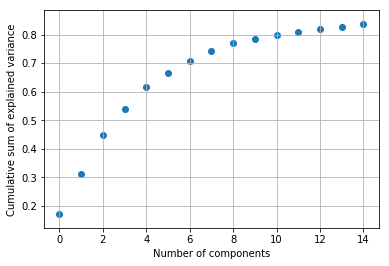

In [20]:
# PCA
n_components = 15
pca = decomposition.PCA(n_components=15)
pca.fit(act_train)

# plot
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/DF/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [21]:
X_train = pca.transform(act_train)
X_train_all = pca.transform(act_train_all)
X_test = pca.transform(act_test)

#### Visualize PCA

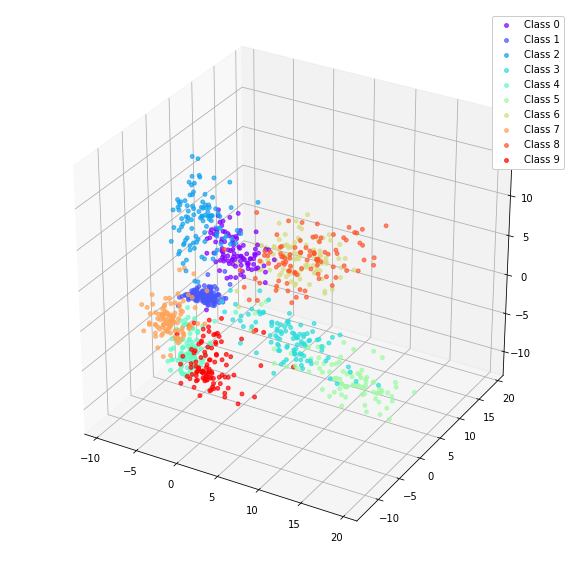

In [22]:
# test sample (with unseen class)
plot_pts_3d(X_test, y_test_label, classes_to_keep, names, colors, subsample_pct=.1)

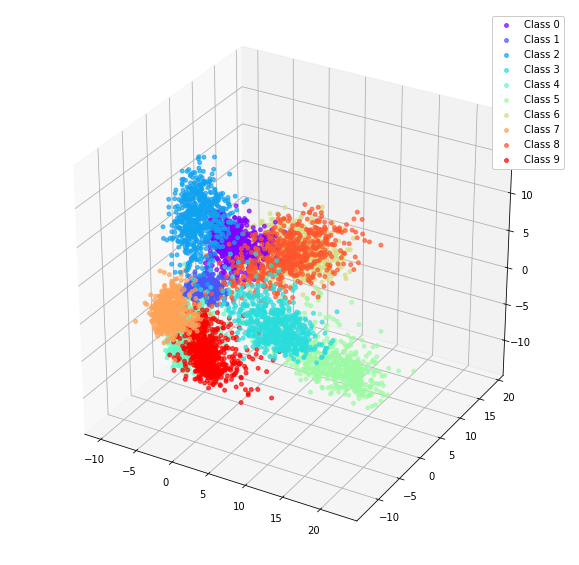

In [23]:
# training sample (without unseen class)
y_pca = y_train_label[pred_t_tr][:len(X_train)]
plot_pts_3d(X_train, y_pca, classes_to_keep, names, colors, subsample_pct=.1)

In [24]:
# t-SNE visualization after PCA
%time tsne_all = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 0.821s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.450588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.570442
[t-SNE] Error after 300 iterations: 2.658143
CPU times: user 59.7 s, sys: 37.1 

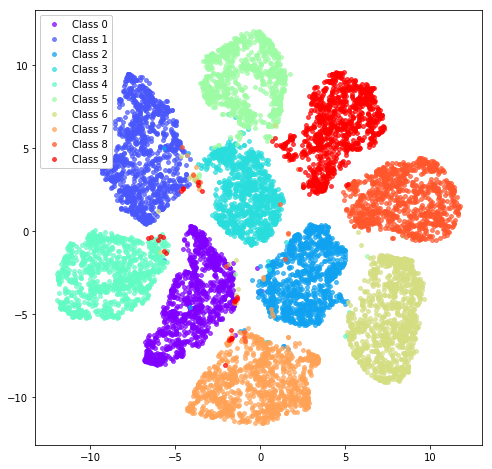

In [25]:
# plot
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_pts_2d(tsne_all, y_test_label, ax, classes_to_keep, names,
           colors, subsample_pct=1)

### GMM
GMM, calculate 

In [26]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

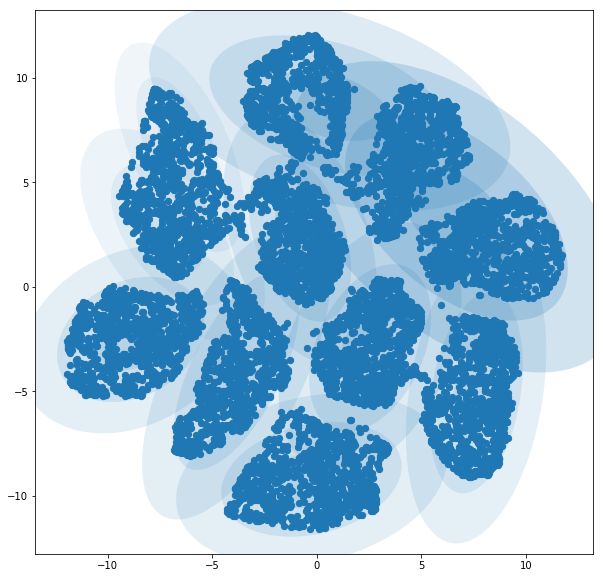

In [27]:
gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=10000)
fig, axes = plt.subplots(1,1,figsize=(10,10))
plot_gmm(gmm, tsne_all, label=False, ax=axes)

In [28]:
def scorer_roc_probas_gmm(gmm, X, y=None):
    """
    custom scorer for cross validation returning AUROC
    :param gmm: GMM classifier
    :param X: validation data
    :param y: optional gt data
    """
    probas = gmm.predict_proba(X)
    
    probas = -get_acc_net_entropy(probas)
    AUROC = metrics.roc_auc_score(y, probas)
    
    return AUROC

In [32]:
import itertools as it 

class ParameterSearch():
    """
    class for performing cross validation, using a training set, test set and a custom scoring function
    to evaluate a model.
    :param model: Model to train on x_train and predict on x_test
    :param params_test: parameters to try for model
    :param x_train: training data
    :param x_test: prediction data
    :param scoring: scoring function taking as input (model, X_test, y_test)
    
    
    """
    def __init__(self, model, params_test, x_train, x_test, y_true, f_scoring, n_iter, verbosity=0, n_jobs=-1):
        """
        :param n_iter: number of iterations for each experiment (take mean)
        """
        # TODO implement parallelization
        self.model = model
        self.params_test = params_test
        self.x_train = x_train
        self.x_test = x_test
        self.f_scoring = f_scoring
        self.y_true = y_true
        self.verbosity = verbosity
        self.n_iter = n_iter
        if n_jobs == -1:
            self.n_jobs = multiprocessing.cpu_count()
        else:
            self.n_jobs = np.min([n_jobs, multiprocessing.cpu_count()])
            
        import itertools as it

        # all possible parameter combinations for all lists of parameters to test
        
        self.combinations=[]
        for p_test_l in params_test:
            params_names = sorted(p_test_l)
            combinations_l = it.product(*(p_test_l[Name] for Name in params_names))
            self.combinations.append([{n:k for k, n in zip(c, params_names)} for c in combinations_l])
        
    def fit(self):
        self.results = {}
        
        results = Parallel(n_jobs=self.n_jobs, verbose=self.verbosity)(
            delayed(self.fit_iter)(c) for c in np.concatenate(self.combinations))
    
        for c, r in zip(np.concatenate(self.combinations), results):
            self.results[str(c)] = r
        
        # best parameters = those with highest score
        self.best_params = np.concatenate(ps.combinations)[np.argmax(list(ps.results.values()))]
        
        
    def fit_iter(self, c):
        score_m = []
        for _ in range(self.n_iter):
            self.model_try = self.model(**c)
            self.model_try.fit(self.x_train)
            score_m.append(self.f_scoring(self.model_try, self.x_test, self.y_true))
        return np.mean(score_m)
        

        
    def __format__():
        """
        Output information on Parameter Search class
        """
        # TODO implement
        pass 
        

In [33]:
y_true_tr = (y_train_label != y_pred_label_tr)*1
tuned_parameters = [{'n_components': np.arange(1,15)}]

# do parameter search
ps = ParameterSearch(GaussianMixture, tuned_parameters, X_train, X_train_all, y_true_tr, scorer_roc_probas_gmm, n_iter=2,
                    verbosity=10, n_jobs=-1)
ps.fit()

[Parallel(n_jobs=40)]: Done   3 out of  14 | elapsed:    3.7s remaining:   13.7s
[Parallel(n_jobs=40)]: Done   5 out of  14 | elapsed:    5.1s remaining:    9.1s
[Parallel(n_jobs=40)]: Done   7 out of  14 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=40)]: Done   9 out of  14 | elapsed:   10.1s remaining:    5.6s
[Parallel(n_jobs=40)]: Done  11 out of  14 | elapsed:   18.3s remaining:    5.0s
[Parallel(n_jobs=40)]: Done  14 out of  14 | elapsed:   21.3s finished


In [34]:
ps.results

{"{'n_components': 10}": 0.9569549319895598,
 "{'n_components': 11}": 0.8614064456312007,
 "{'n_components': 12}": 0.8393332048856639,
 "{'n_components': 13}": 0.8022283358881994,
 "{'n_components': 14}": 0.7748696324785639,
 "{'n_components': 1}": 0.5,
 "{'n_components': 2}": 0.8608365584318056,
 "{'n_components': 3}": 0.8785675382975251,
 "{'n_components': 4}": 0.8816365201142331,
 "{'n_components': 5}": 0.890740736325904,
 "{'n_components': 6}": 0.9096625301171135,
 "{'n_components': 7}": 0.8727182568278642,
 "{'n_components': 8}": 0.9390245620407662,
 "{'n_components': 9}": 0.9329482576232573}

In [35]:
ps.results


{"{'n_components': 10}": 0.9569549319895598,
 "{'n_components': 11}": 0.8614064456312007,
 "{'n_components': 12}": 0.8393332048856639,
 "{'n_components': 13}": 0.8022283358881994,
 "{'n_components': 14}": 0.7748696324785639,
 "{'n_components': 1}": 0.5,
 "{'n_components': 2}": 0.8608365584318056,
 "{'n_components': 3}": 0.8785675382975251,
 "{'n_components': 4}": 0.8816365201142331,
 "{'n_components': 5}": 0.890740736325904,
 "{'n_components': 6}": 0.9096625301171135,
 "{'n_components': 7}": 0.8727182568278642,
 "{'n_components': 8}": 0.9390245620407662,
 "{'n_components': 9}": 0.9329482576232573}

In [36]:
ps.best_params

{'n_components': 10}

## Novelty Detection on Activations:
- One-class SVM
- Isolation Forest

### One-class SVM

In [55]:
def scorer_roc_probas_svm(svm, X, y=None):
    """
    custom scorer for cross validation returning AUROC
    :param svm: svm classifier
    :param X: validation data
    :param y: optional gt data
    """
    probas = -svm.decision_function(X)
    
    AUROC = metrics.roc_auc_score(y, probas)
    
    return AUROC

In [ ]:
y_true_tr = (y_train_label != y_pred_label_tr)*1
tuned_parameters=[{'kernel':['rbf'],
                   'nu':[.04, .2, .5], 
                   'max_iter'=100000
                  },
                  {'kernel':['poly'],
                   'degree':np.arange(2,9),
                   'nu':[.04, .2, .5], 
                   'max_iter'=100000}]

# do parameter search
ps = ParameterSearch(svm.OneClassSVM, tuned_parameters, X_train, X_train_all, y_true_tr, scorer_roc_probas_svm, n_iter=2,
                    verbosity=10, n_jobs=1)
#ps.fit()

In [ ]:
clf_svm = svm.OneClassSVM(kernel='poly', degree=5, nu=.04, max_iter=100000)

In [73]:
clf_svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=5, gamma='auto', kernel='poly',
      max_iter=100000, nu=0.04, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [74]:
probas = clf_svm.decision_function(X_test)
probas -= np.min(probas)
probas /= np.max(probas)

In [75]:
#predict
probas = clf_svm.predict(X_test)

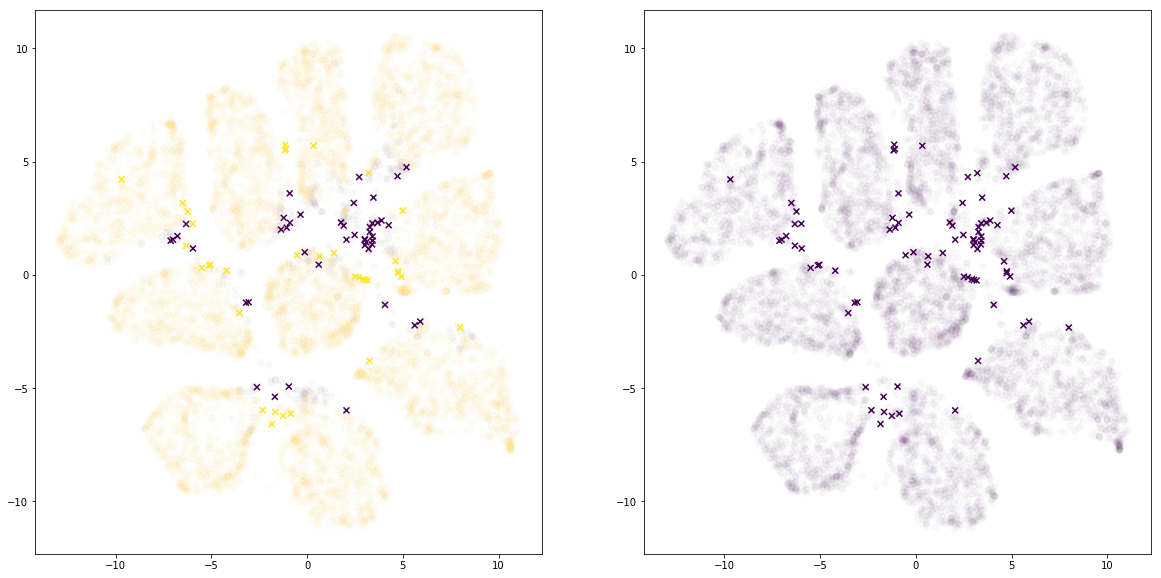

In [76]:
# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1,2,figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=probas[pred_t_te], alpha=.02) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=(probas<np.sort(probas)[300])[pred_t_te], alpha=.02)  # 300 least certain points in yellow

# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
axes[0].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=probas[pred_f_te], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=(probas<np.sort(probas)[300])[pred_f_te], marker='x')  # 300 least certain points in yellow

In [77]:
# Metrics
# PR
precision_svm, recall_svm, thresholds = metrics.precision_recall_curve(y_true, -probas)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)
# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, -probas)
roc_auc_svm = metrics.roc_auc_score(y_true, -probas)

# Density Forest

In [53]:
root_nodes = df_create(X_train, max_depth=5, min_subset=.1, n_trees=10, subsample_pct=.1, 
          n_max_dim=0, n_jobs=-1, verbose=1, fact_improvement=.01)

Number of points on which to train each tree: 1000
Minimum number of points in each leaf: 100


[Parallel(n_jobs=40)]: Done   8 out of  10 | elapsed:    8.4s remaining:    2.1s


Number of created root nodes: 10
Mean number of clusters created per tree: 14


[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:    8.6s finished


In [54]:
probas = df_traverse(X_test, root_nodes, thresh=0)

0.06086705027618957

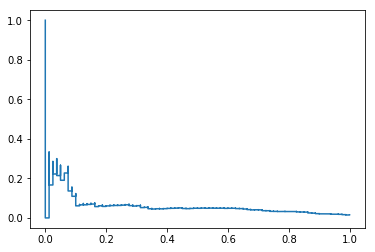

In [55]:
# precision-recall curve
y_scores = -probas
precision_df, recall_df, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_df = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_df, precision_df)
metrics.auc(recall_df, precision_df)

## Plot Results

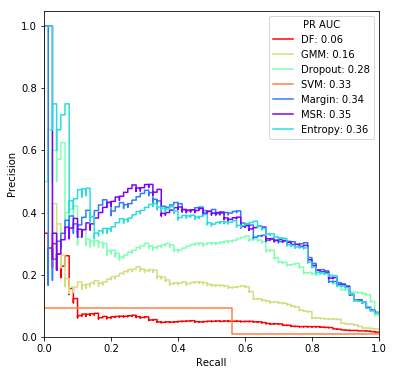

In [78]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]
recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, precision_gmm, precision_svm, precision_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_pr)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/MNIST/PR_ED.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

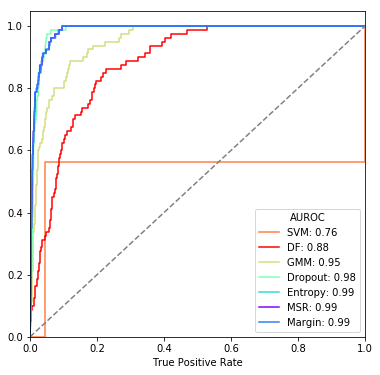

In [79]:
# ROC
# order according to increasing score
scores_auc = [roc_auc_msr, roc_auc_margin, roc_auc_entropy, roc_auc_dropout, roc_auc_gmm, roc_auc_svm, roc_auc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_auc)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0,1],[0,1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/MNIST/ROC_ED.pdf", bbox_inches='tight', pad_inches=0)
plt.show()